# Portuguese grade estimation using mathematics grades and student information.

<i> Morgane Brossard, Adrian Durando, Clément Ferrere, Rémi Khoury, Guillaume Pradel, Romain Torris </i>

# Introduction

Education is a fundamental pillar of societal progress, and understanding the factors that influence student performance can lead to more effective teaching strategies and interventions, for instance identify at-risk students early on. This challenge is based on a real-world dataset collected from two Portuguese secondary schools in 2005-2006. The data includes a variety of student features such as demographics, social factors, school-related characteristics, and academic performance in the subjects of Portuguese language and Mathematics.

The authors of the study that produced this dataset predicted success in both subjects separately, but in this challenge we will take a new approach aiming to leverage potential links between both academic performances.



### Goal of this challenge
The goal of this challenge is to predict students' Portuguese grades using all other available (non-academic) information, and their Mathematics grades. By integrating these two subjects, we aim to uncover the extent to which performance in one subject can inform success in another, especially with two varied core subjects that tackle different skills.

### Datasets and task

For training, participants have access to a dataset consisting in a list of 370 students from the two schools in the original study. The data (see table below taken from the original article) contains numerical and categorical features:
- non-academic elements such as age, address, quality of the family relationships, access to Internet
- academic elements for the Mathematics subject such as the first, second period and final grade
- academic elements for the Portuguese subject such as absences and failures, but no information about grades.

Please note that the dataset for this challenge is slightly different than the structured presented here from the original article, as we modified and merged datasets used in the original article. See the exploratory data analysis for more details on the datasrt.



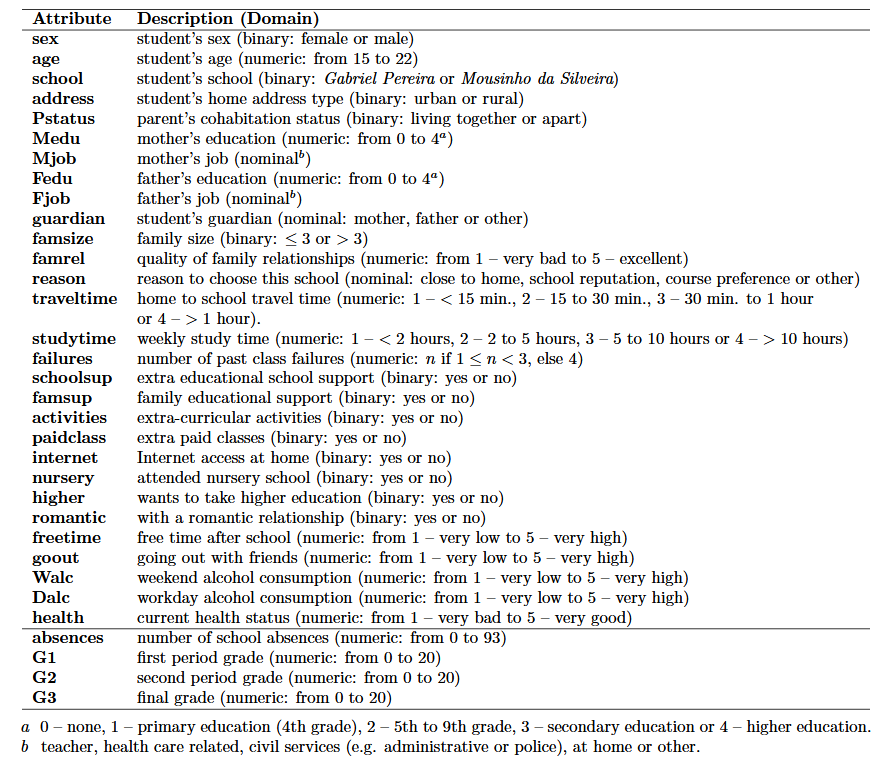

This challenge is a regression task. Participants will build predictive models to leverage features (to their liking) from all the information available, to predict the final Portuguese grade (= 'G3_por') of the students.

# Exploratory data analysis

This notebook provides a simple exploratory data analysis of the dataset.

In [39]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


In [40]:
# Check that the 'data' folder exists and is not empty
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Error: The 'data' folder does not exist. You can't continue without loading the data...")
    print("Please run [ !python3 download.py] before running this script")

elif not os.listdir(data_folder):
    print("Error: The 'data' folder is empty. You can't continue without loading the data...")
    print("Please run [ !python3 download.py] before running this script")

## Get access to the training data


In [41]:
import problem

X_df, y = problem.get_train_data()

# reconstitute the column used for y (ie. the data we want to predict)
X_df['G3_por'] = y

In [42]:
print(X_df.shape)

(296, 35)


The training dataset contains data from 296 students, with 35 descriptive features each. All of these students participated in both mathematics and Portuguese courses. The dataset is clean and does not contain any missing values.

In [43]:
X_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures_math,schoolsup,famsup,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences_math,G1_math,G2_math,G3_math,failures_por,absences_por,G3_por
0,MS,M,18,R,GT3,T,1,3,at_home,other,course,mother,2,2,0,no,yes,no,yes,yes,no,no,3,3,4,2,4,3,4,10,10,10,0,0,9
1,GP,M,16,R,LE3,T,3,3,teacher,other,home,father,3,1,0,no,yes,yes,yes,yes,yes,no,3,3,4,3,5,3,8,9,9,10,0,16,12
2,GP,M,15,U,GT3,T,4,3,teacher,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,no,4,3,3,2,3,5,6,9,9,10,0,0,11
3,GP,F,15,U,GT3,T,1,1,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,4,3,2,2,3,4,2,9,10,10,0,2,12
4,MS,M,18,U,GT3,T,4,4,teacher,teacher,home,father,1,2,0,no,no,yes,no,yes,yes,no,3,2,4,1,4,2,4,15,14,14,0,4,19


In [44]:
description= X_df.describe()
description = description.drop(['count','std','25%','50%','75%'], axis=0)
description = description.drop(['Fedu','Medu'], axis=1)
description

,age,traveltime,studytime,failures_math,famrel,freetime,goout,Dalc,Walc,health,absences_math,G1_math,G2_math,G3_math,failures_por,absences_por,G3_por
mean,16.60473,1.483108,2.023649,0.283784,3.939189,3.216216,3.162162,1.489865,2.327703,3.554054,5.435811,10.817568,10.692568,10.310811,0.118243,3.733108,12.523649
min,15.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22.00000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000,3.000000,32.000000,19.000000


Let's print the shape of the target data compared to another data provided by the datset :

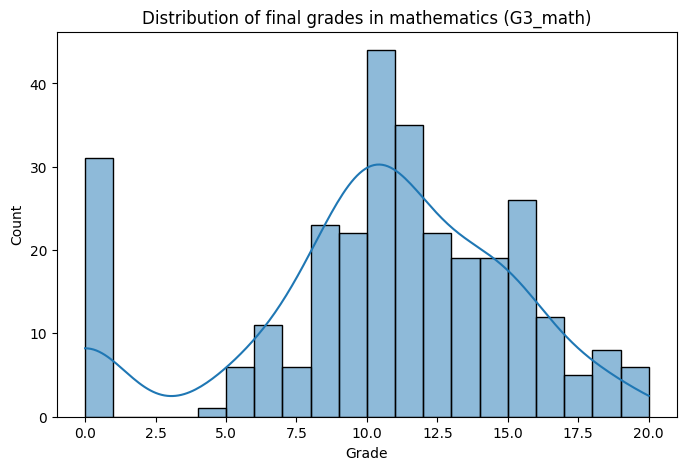

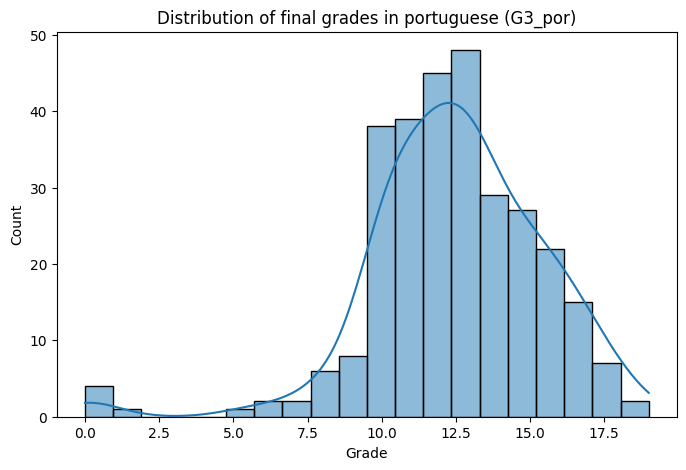

In [45]:
# training variable distribution in math
plt.figure(figsize=(8, 5))
sns.histplot(X_df['G3_math'], bins=20, kde=True)
plt.title("Distribution of final grades in mathematics (G3_math)")
plt.xlabel("Grade")
plt.show()

# target variable distribution (portugese grades)
plt.figure(figsize=(8, 5))
sns.histplot(X_df['G3_por'], bins=20, kde=True)
plt.title("Distribution of final grades in portuguese (G3_por)")
plt.xlabel("Grade")
plt.show()

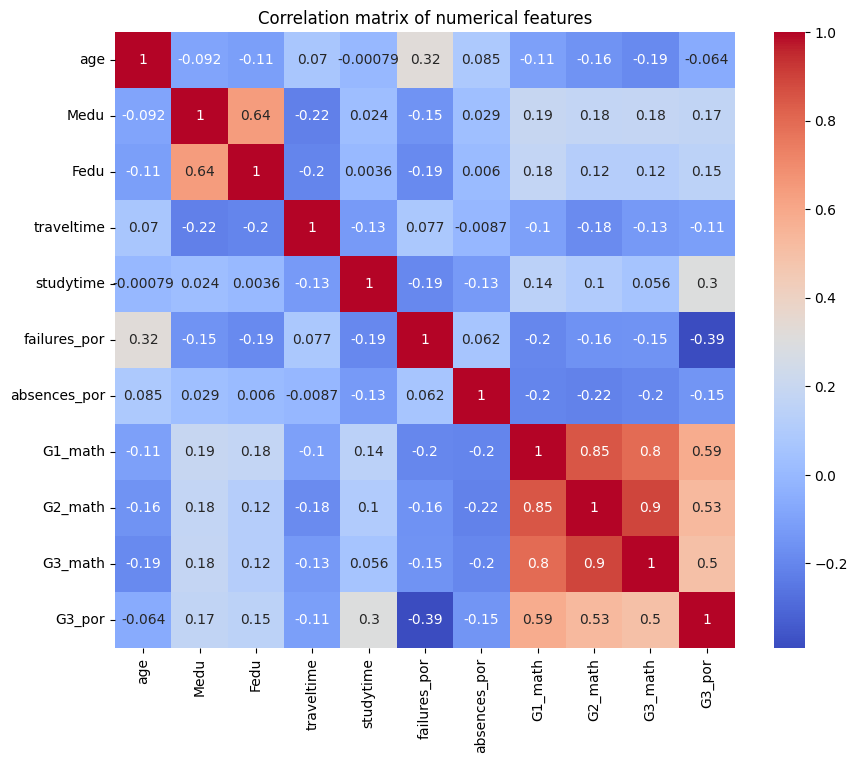

In [46]:
# Analysis of numerical correlations.
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures_por',
                     'absences_por', 'G1_math', 'G2_math','G3_math']
corr_matrix = X_df[numerical_features + ['G3_por']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation matrix of numerical features")
plt.show()

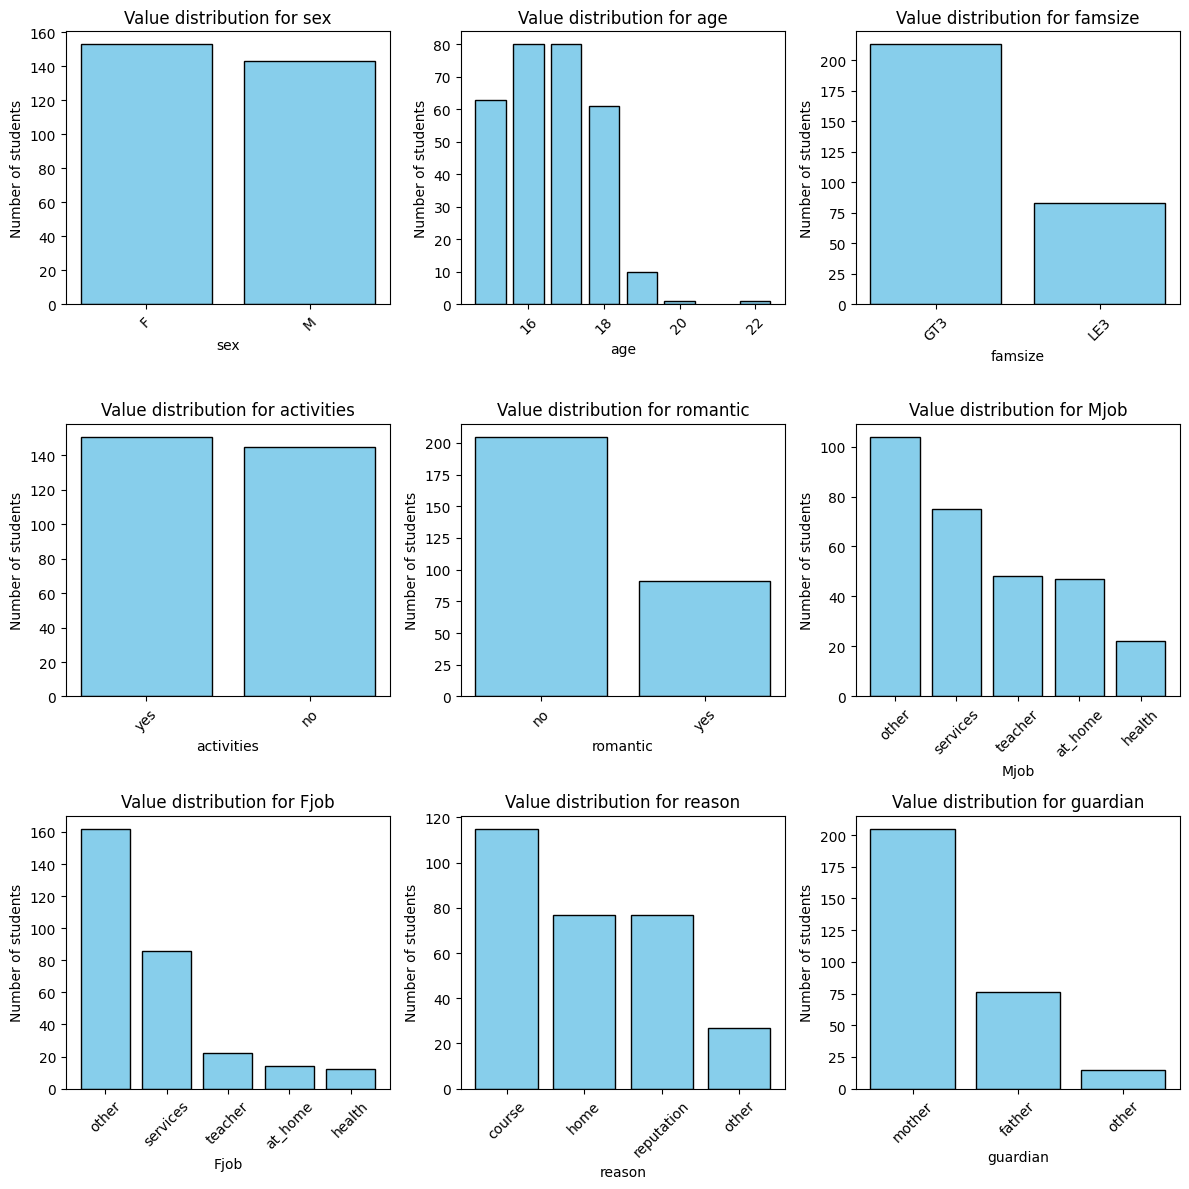

In [47]:
# plot some categoric features, to fin out the distribution of each class
features_categoric = ['sex','age', 'famsize', 'activities', 'romantic', 'Mjob', 'Fjob', 'reason', 'guardian']

# Creation of distribution plots
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

axes = axes.flatten()

for i, feature in enumerate(features_categoric):
    axes[i].bar(X_df[feature].value_counts().index, X_df[feature].value_counts(), color='skyblue', edgecolor='black')
    axes[i].set_title(f"Value distribution for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Number of students")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

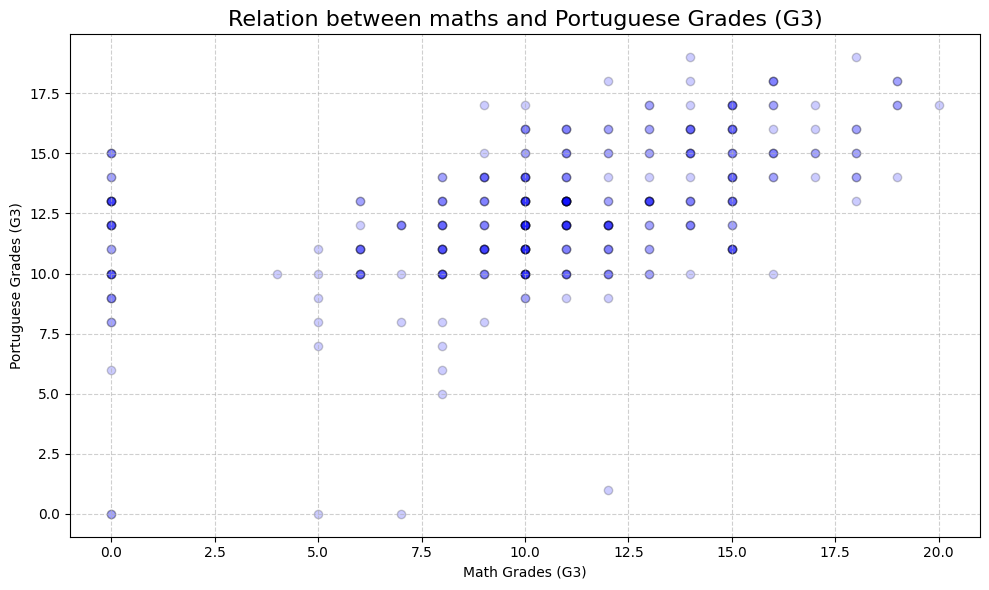

In [48]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_df['G3_math'], X_df['G3_por'], color='blue', edgecolors='black', alpha=0.2)
plt.title('Relation between maths and Portuguese Grades (G3)',fontsize=16)
plt.xlabel('Math Grades (G3)')
plt.ylabel('Portuguese Grades (G3)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Challenge Evaluation

For this challenge, the metric used to evaluate the model's performance is the **Mean Squared Error (MSE)** between the **predicted MAP** and the **actual MAP**, defined as follows:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{pred}^i - y_{true}^i)^2
$$

Here, we calculate the **MSE** on the test set, which consists of signals from domain \( m \).

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [49]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def get_estimator():
    num_processor = "passthrough"
    num_columns = ["G1_math", "G2_math", 'G3_math']

    preprocessor = make_column_transformer(
        (num_processor, num_columns),
        remainder="drop",
    )

    return make_pipeline(preprocessor, RandomForestRegressor())

## Testing using a scikit-learn pipeline

In [50]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

model = get_estimator()
y_pred = model.fit(X_train, y_train).predict(X_test)

from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE on test: ', score)

MSE on test:  2.6934230643023973


## Testing using ramp-workflow

In [51]:
!ramp-test --submission starting_kit --quick-test

Testing Portuguese grade estimation
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse      time
	train  1.659  0.323731
	valid  2.495  0.016779
	test   2.617  0.013036
CV fold 1
	score   rmse      time
	train  1.638  0.165004
	valid  2.597  0.015383
	test   2.670  0.013930
CV fold 2
	score   rmse      time
	train  1.667  0.184172
	valid  2.434  0.014912
	test   2.824  0.013023
CV fold 3
	score   rmse      time
	train  1.684  0.157747
	valid  2.089  0.015208
	test   2.603  0.013313
CV fold 4
	score   rmse      time
	train  1.639  0.168916
	valid  2.464  0.016572
	test   2.512  0.013614
----------------------------
Mean CV scores
----------------------------
	score            rmse        time
	train  1.657 ± 0.0174  0.2 ± 0.06
	valid  2.416 ± 0.1724   0.0 ± 0.0
	test   2.645 ± 0.1027   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score   rmse
	valid  2.502
	test   2.584


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).